<a href="https://www.thestar.com/news/gta/2015/01/29/toronto-named-best-place-to-live-by-economist.html"><img src="https://images.thestar.com/rUBBQ4wwcPOP0uWHRcEKKJQA21w=/1200x740/smart/filters:cb(2700061000)/https://www.thestar.com/content/dam/thestar/news/gta/2015/01/29/toronto-named-best-place-to-live-by-economist/dc0918141496e-1.jpg" width="700" align="center"></a>

<h1 align="center"><font size="5">Segmenting and Clustering Neighborhoods in Toronto</font></h1>

In this Nootbook the following codes aime  to explore and cluster the neighborhoods in Toronto. The rowdata used here will be imported from the <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">Wikipidia page</a>  utilising the <a href="https://beautiful-soup-4.readthedocs.io/en/latest/">BeautifulSoup</a> package
# Import libraries

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
# import k-means from clustering stage
from sklearn.cluster import KMeans
! pip install folium
import folium
import numpy as np 
!pip install -U scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

Requirement already up-to-date: scikit-learn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.23.2)


# 1- Data acquisition
### Utilizing BeautifulSoup and requests libraries to extract a table from the Wikipedia page

In [2]:
# make a soup from the page 
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'lxml')
#construct the table row by row
data = []
table = soup.findAll('table')[0] 
table_body = table.find('tbody')
rows = table_body.findAll('tr')
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])
# tabe is construct as a list. Now we convert it to a datat frame and add the headders and drop the lines that have a None element
df = pd.DataFrame(data, columns = ['PostalCode' , 'Borough', 'Neighborhood' ]).dropna() 
# Delete these rows where Borough is not assigned from dataFrame
df.drop(df[ df['Borough'] == 'Not assigned' ].index , inplace=True)
#rest the index 
df=df.reset_index(drop=True)
#check if there are rows where Neighboorhood is not assigned
if 'Not assigned' not in df.values:
    print('All Neighboorhood are assigned and we are ready to go')
    print ('The size of the data frame is', df.shape)
df.head(12)

All Neighboorhood are assigned and we are ready to go
The size of the data frame is (103, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


# 2- Geo coordinates acquisition 
### Using the Geocoder import the coordinates for each Borough
First the  __geocoder__  will be used, then for training on alternative solutions purpose, the scv file will be used as well. It happen sometimes that the  __geocoder__ retrieve no values (coordinates) and the simple solution is to repeat the request, to avoid  facing this problem the following code will iterate throw the rows of the data frame and keep repeating the coordinates request from the geocoder until a value is received.In this code __the ArcGis__ decoder is used, but it is not the only option, there are many others like  Google Maps, AzureMaps, Bing, etc. Some of them require API keys, while others do not need.

In [3]:
# make a copy of the data to work on it NH_data refere to Neighborhoods data 
NH_data= df
#initiate an empty vector to store the latitude and longtiude values for following merge with the data frame 
latitude = []
longitude = []

#now loop in the whole table to retrieve all the coordenates for all addresses 
for index, row in NH_data.iterrows():
    
# initialize your variable to None
 lat_lng_coords = None

# loop until you get the coordinates
 while(lat_lng_coords is None):
   g = geocoder.arcgis('{}, Toronto, Ontario'.format(df.loc[index,'PostalCode'])) 
   lat_lng_coords = g.latlng

 latitude.append(lat_lng_coords[0])
 longitude.append(lat_lng_coords[1])
NH_data["Latitude"] = latitude
NH_data["Longitude"] = longitude
NH_data.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75188,-79.33036
1,M4A,North York,Victoria Village,43.73042,-79.31282
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72321,-79.45141
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66449,-79.39302
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.66277,-79.52831
6,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552
7,M3B,North York,Don Mills,43.74929,-79.36169
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70794,-79.31160
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.65736,-79.37818


# 3- Exploring the data and cluster the neighbouhoods

In [4]:
#how many broughs and neighborhoods are there
print('The dataframe has {} boroughs and at least {} neighborhoods.'.format(
        len(NH_data['Borough'].unique()),
        NH_data.shape[0]
    )
)

The dataframe has 10 boroughs and at least 103 neighborhoods.


Find the coordinates of the Toronto, Ontario so we can generate the first map based on those coordenates

In [5]:
g = geocoder.arcgis(' Toronto')
lat_lng_coords = g.latlng
latitude= lat_lng_coords[0]
longitude= lat_lng_coords[1]
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.648690000000045, -79.38543999999996.


#### Create a map of New Toronto with neighborhoods superimposed on top.

In [6]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(NH_data['Latitude'], NH_data['Longitude'], NH_data['Borough'], NH_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

work with only boroughs that contain the word Toronto 

In [7]:
Toronto_data = NH_data[NH_data['Borough'].astype(str).str.contains('Toronto')]
Toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66449,-79.39302
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.65736,-79.37818
15,M5C,Downtown Toronto,St. James Town,43.65143,-79.37557
19,M4E,East Toronto,The Beaches,43.67703,-79.29542


In [8]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Borough'], Toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

# Utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define __Foursquare__ Credentials and Version

In [9]:
CLIENT_ID = 'RLPEZLL2EAEGYDAWKWP4IBTZAE3LNXLAVF5F1JR2RD2SVZG1' # your Foursquare ID
CLIENT_SECRET = 'YFP34GXZLY0QEG0DAECMNBQGHHLFUZN10STYUEJVDST5QP11' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100
radius = 500

Your credentails:
CLIENT_ID: RLPEZLL2EAEGYDAWKWP4IBTZAE3LNXLAVF5F1JR2RD2SVZG1
CLIENT_SECRET:YFP34GXZLY0QEG0DAECMNBQGHHLFUZN10STYUEJVDST5QP11


# Explore Neighborhoods in Toronto

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Toronto_venues = getNearbyVenues(names=Toronto_data['Neighborhood'],
                                   latitudes=Toronto_data['Latitude'],
                                   longitudes=Toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [11]:
# Check the size of the resulting dataframe
print(Toronto_venues.shape)
Toronto_venues.head()

(1753, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65514,-79.36265,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65514,-79.36265,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65514,-79.36265,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
3,"Regent Park, Harbourfront",43.65514,-79.36265,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
4,"Regent Park, Harbourfront",43.65514,-79.36265,Body Blitz Spa East,43.654735,-79.359874,Spa


In [90]:
# Check how many venues were returned for each neighborhood
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,68,68,68,68,68,68
"Brockton, Parkdale Village, Exhibition Place",86,86,86,86,86,86
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",74,74,74,74,74,74
Central Bay Street,73,73,73,73,73,73
Christie,11,11,11,11,11,11
Church and Wellesley,74,74,74,74,74,74
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,26,26,26,26,26,26


#### Find out how many unique categories can be curated from all the returned venues

In [13]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 225 uniques categories.


## Analyze Each Neighborhood

In [14]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# define a list of column names
cols = Toronto_onehot.columns.tolist()
# move the column name to the beggining
cols.insert(0, cols.pop(cols.index('Neighborhood')))
#then use .reindex() function to reorder
Toronto_onehot = Toronto_onehot.reindex(columns= cols)

#check result
Toronto_onehot.head()


,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
this will define a patern or category of the neighborhood by the number and the kind of a certain venue in correlation to the other neighborhoods

In [15]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,0.000000,...,0.00,0.000000,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.014706
1,"Brockton, Parkdale Village, Exhibition Place",0.011628,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.011628,...,0.00,0.000000,0.011628,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.011628
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.020000,0.000000,0.000000,0.010000,0.000000,0.010000,0.030000,...,0.00,0.000000,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,...,0.00,0.027027,0.000000,0.000000,0.000000,0.000000,0.000000,0.013514,0.00,0.013514
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.013699,0.013699,0.000000,0.000000,...,0.00,0.000000,0.000000,0.013699,0.013699,0.013699,0.000000,0.000000,0.00,0.000000
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Church and Wellesley,0.000000,0.013514,0.013514,0.000000,0.000000,0.000000,0.000000,0.013514,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.013514
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.040000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,...,0.00,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.010000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


### Now write a function to sort the venues in descending order.

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [35]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Restaurant,Café,Hotel,Seafood Restaurant,Lounge,Bakery,Farmers Market,Beer Bar,Italian Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Bar,Restaurant,Gift Shop,Sandwich Place,Supermarket,Japanese Restaurant,Furniture / Home Store,French Restaurant
2,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Italian Restaurant,Bar,Restaurant,Asian Restaurant,Seafood Restaurant,Thai Restaurant,Concert Hall,Steakhouse
3,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Italian Restaurant,Bar,Café,Gym / Fitness Center,Speakeasy,Train Station,Park,Bakery,Sandwich Place
4,Central Bay Street,Coffee Shop,Clothing Store,Bubble Tea Shop,Sushi Restaurant,Sandwich Place,Middle Eastern Restaurant,Electronics Store,Cosmetics Shop,Hotel,Plaza


# Cluster Neighborhoods

In [18]:
# drop the first coloumn as we dont need the nieghborhood's names for the cluster analysis
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

For chosing the __Optimal k value__ the elbow vesual apporoach will be used here 



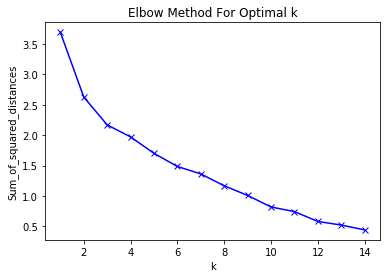

In [19]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## Optimal k =3

In [85]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 2, 0, 0, 1, 0, 2, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0], dtype=int32)

In [86]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Toronto_merged = Toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged.reset_index(drop=True, inplace=True)
Toronto_merged=Toronto_merged.drop([19])
#Toronto_merged.reset_index(drop=True, inplace=True)
Toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265,0.0,Coffee Shop,Breakfast Spot,Yoga Studio,Thai Restaurant,Italian Restaurant,Food Truck,Event Space,Electronics Store,Distribution Center,Pub
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66449,-79.39302,0.0,Coffee Shop,Café,Sandwich Place,Park,College Theater,Burger Joint,Salon / Barbershop,Chinese Restaurant,Restaurant,Clothing Store
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.65736,-79.37818,0.0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Japanese Restaurant,Theater,Hotel,Diner,Fast Food Restaurant
3,M5C,Downtown Toronto,St. James Town,43.65143,-79.37557,0.0,Seafood Restaurant,Coffee Shop,Café,Restaurant,Clothing Store,Cocktail Bar,Cosmetics Shop,American Restaurant,Park,Lingerie Store
4,M4E,East Toronto,The Beaches,43.67703,-79.29542,2.0,Health Food Store,Pub,Trail,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space


Finally the vesiual results 

In [87]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [88]:
del neighborhoods_venues_sorted['Cluster Labels']
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Restaurant,Café,Hotel,Seafood Restaurant,Lounge,Bakery,Farmers Market,Beer Bar,Italian Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Bar,Restaurant,Gift Shop,Sandwich Place,Supermarket,Japanese Restaurant,Furniture / Home Store,French Restaurant
2,"Business reply mail Processing Centre, South C...",Coffee Shop,Hotel,Italian Restaurant,Bar,Restaurant,Asian Restaurant,Seafood Restaurant,Thai Restaurant,Concert Hall,Steakhouse
3,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Italian Restaurant,Bar,Café,Gym / Fitness Center,Speakeasy,Train Station,Park,Bakery,Sandwich Place
4,Central Bay Street,Coffee Shop,Clothing Store,Bubble Tea Shop,Sushi Restaurant,Sandwich Place,Middle Eastern Restaurant,Electronics Store,Cosmetics Shop,Hotel,Plaza
